In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from tqdm import tqdm

In [7]:
def zip_map(zipped, update_op):
    return [update_op(*elems) for elems in zipped]

def euler_update(h_list, dh_list, dt):
    return zip_map(zip(h_list, dh_list), lambda h, dh: h + dt * dh)

def euler_step(func, dt, state):
    return euler_update(state, func(state), dt)

In [8]:
import adjoint_ode

Рассмотрим дифур: $r''=-r$

Запишем его в виде:
$$v'=-r$$
$$r'=v$$

In [9]:
class ODE_equation(nn.Module):
    
    def forward(self, inputs):
        t, state = inputs
        r_vec, v_vec = state[:2], state[2:] 
        
        return torch.cat([v_vec, -r_vec])

In [10]:
num_steps = 1000
v0 = torch.Tensor([1., 1.])
r0 = torch.Tensor([1., 0.])
init_state = torch.cat([r0, v0], 0)

In [11]:
neural_ode = adjoint_ode.AdjointODE(ode_model=ODE_equation(), timestamps=np.linspace(0., 10, 100), ode_solver=euler_step)

## 1. Решим система методом Эйлера

In [12]:
states_history = neural_ode.forward(init_state)

In [13]:
trajectory = np.stack(states_history)
trajectory.shape

(100, 4)

In [14]:
# Function for plotting the trajectory
def plot_trajectory(trajectories, labels):
    for trajectory, label in zip(trajectories, labels):
        plt.plot(*trajectory[:, :2].T, label=label)
        
    n = trajectory.shape[0]
    plt.plot(np.linspace(-2, 2, n), np.zeros(n), 'k-')
    plt.plot(np.zeros(n), np.linspace(-2, 2, n), 'k-')
    plt.plot(0, 2, 'rx', label='target', lw=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.legend()
    plt.show()

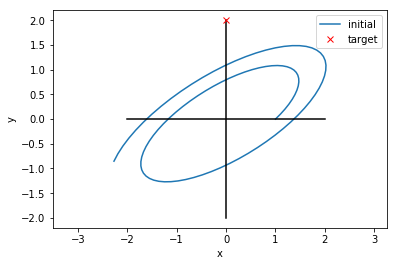

In [15]:
plot_trajectory([trajectory], ["initial"])

Зададим финальную точку траектории

In [16]:
v0 = torch.Tensor([1., 1.])
r0 = torch.Tensor([0., 2.])
target_state = torch.cat([r0, v0], 0)

In [17]:
neural_ode = adjoint_ode.AdjointODE(ode_model=ODE_equation(), timestamps=np.linspace(0., 10, 100), ode_solver=euler_step)

In [18]:
start_state = torch.Tensor(init_state)
start_state.requires_grad_(True)

tensor([1., 0., 1., 1.], requires_grad=True)

## 2. Оптимизируем обычным градиентным спуском

In [19]:
loss_history = []
for step in tqdm(range(1000)):
    end_state = neural_ode.forward(start_state)[-1]
    loss = torch.sum((end_state[:2] - target_state[:2])**2)        
    dLoss = torch.autograd.grad(loss, start_state)[0]
    dLoss = torch.Tensor([0, 0, dLoss[2], dLoss[3]])    
    start_state = start_state - 0.01*dLoss
    loss_history.append(loss)

100%|██████████| 1000/1000 [00:11<00:00, 86.41it/s]


In [20]:
opt_states_history = neural_ode.forward(start_state)
opt_states_history = torch.stack(opt_states_history).detach().numpy()
opt_trajectory = np.stack(opt_states_history)

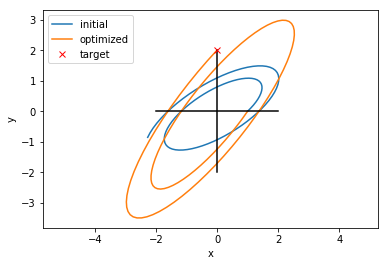

In [21]:
plot_trajectory([trajectory, opt_trajectory], ["initial", "optimized"])

## 3. Обучим по adjoint методу

In [23]:
opt_neural_ode = adjoint_ode.AdjointODE(ode_model=ODE_equation(), timestamps=np.linspace(0., 10, 100), ode_solver=euler_step)

In [24]:
start_state = torch.Tensor(init_state)
start_state.requires_grad_(True)

tensor([1., 0., 1., 1.], requires_grad=True)

In [31]:
loss_history = []
for step in tqdm(range(100)):
    end_state = opt_neural_ode.forward(start_state)[-1]
    end_position = end_state[:2]
    target_position = target_state[:2]
    loss = torch.sum((end_position - target_position)**2)
    dLoss = torch.autograd.grad(loss, end_state)[0]
    
    h_start, dfdh0, dWeights = opt_neural_ode.backward(end_state, dLoss)
    dLoss = torch.Tensor([0.0, 0.0, dfdh0[2], dfdh0[3]])
    start_state = start_state + 0.05*dLoss
    loss_history.append(loss)

100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


In [32]:
opt_states_history = neural_ode.forward(start_state)
opt_states_history = torch.stack(opt_states_history).detach().numpy()
opt_trajectory = np.stack(opt_states_history)

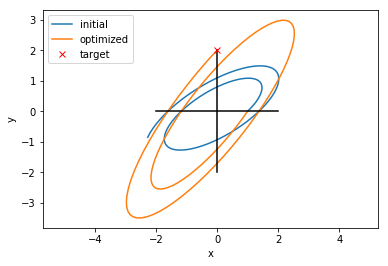

In [33]:
plot_trajectory([trajectory, opt_trajectory], ["initial", "optimized"])